# IMPORTS

In [1]:
import sys 
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import keras
from PIL import Image
from keras.applications import imagenet_utils
import os
import matplotlib.pyplot as plt
import pandas as pd
pd.options.plotting.backend = "plotly"
import tensorflow_model_optimization as tfmot
from tensorflow.keras.applications import mobilenet_v2,resnet,densenet
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing import image
from tqdm import tqdm
from torchvision import datasets, transforms
import shutil
import tensorflow_datasets as tfds

In [2]:
# print version
print('tensorflow:', tf.__version__)
print('keras     :', tf.keras.__version__)

tensorflow: 2.8.0
keras     : 2.8.0


# PREPARE DATA

In [3]:
SPLIT_WEIGHTS = (8, 1, 1)
#splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)
splits = ("train[:80%]", "train[:10%]", "train[:10%]")

In [4]:
(raw_train, raw_validation, raw_test), info = tfds.load(name="tf_flowers",
                                                        with_info=True,
                                                        split=list(splits),
                                                        as_supervised=True)

In [5]:
total_num_examples = info.splits['train'].num_examples

print('total num examples:', total_num_examples)
print('total num examples % 100:', total_num_examples % 100)
print('total num examples =', total_num_examples - (total_num_examples % 100), '+', total_num_examples % 100)

print('num test :', int(3600 * 0.1 + 7))
print('num val  :', int(3600 * 0.1 + 7))
print('num train:', int(3600 * 0.8 + (70 - 14)))

total num examples: 3670
total num examples % 100: 70
total num examples = 3600 + 70
num test : 367
num val  : 367
num train: 2936


In [6]:
IMG_SIZE = 224
SHUFFLE_BUFFER_SIZE = 1000
BATCH_SIZE = 32

In [7]:
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    # Normalize the pixel values
    image = image / 255.0
    # image = (image/127.5) - 1

    # Resize the image if required
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    return image, label

In [8]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [9]:
def augment_data(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_contrast(image, lower=0.1, upper=0.6)

    return image, label

In [10]:
train = train.map(augment_data)
train = train.cache()
train = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation = validation.batch(BATCH_SIZE)
test = test.batch(1)

train = train.prefetch(tf.data.experimental.AUTOTUNE)

In [11]:
print(train)
print(validation)
print(test)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


# DISPLAY IMAGES

In [12]:
# Get the function which converts label indices to string
get_label_name = info.features['label'].int2str

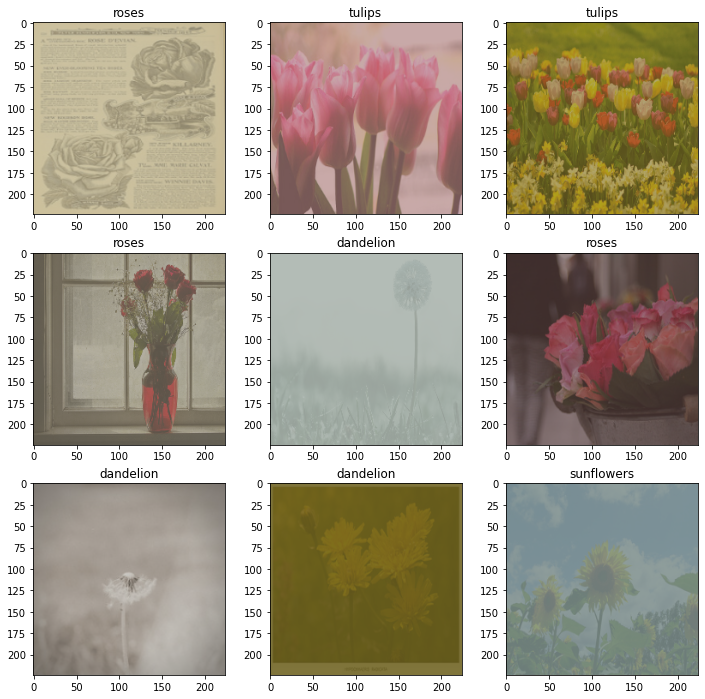

In [13]:
plt.figure(figsize=(12,12)) 

for batch in train.take(1):
  # print(batch)
  for i in range(9):
    image, label = batch[0][i], batch[1][i]
    plt.subplot(3, 3, i+1)
    plt.imshow(image.numpy())
    plt.title(get_label_name(label.numpy()))
    plt.grid(False)    

# LOAD MODEL

In [14]:
SAVE_DIR = './MODELS/'
TFLITE_DIR = './MODELS/TFLITE/'

In [15]:
model = load_model(SAVE_DIR+'MOBILENET_FLOWERS.h5')

base_learning_rate = 1e-4
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss = 'sparse_categorical_crossentropy',
    metrics = ["accuracy"]
)

# EVALUATIONS

In [16]:
num_train = 2936
num_val =  367
num_test = 367

steps_per_epoch = round(num_train) // BATCH_SIZE
validation_steps = round(num_val) // BATCH_SIZE

In [17]:
test_acc = model.evaluate(test, verbose=1)[1]
print('test acc:', str(round(test_acc*100, 3))+"%")

367/367 [==============================] - 8s 9ms/step - loss: 0.2381 - accuracy: 0.9510
test acc: 95.095%


# QAT

In [18]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

q_aware_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 quantize_layer (QuantizeLayer)  (None, 224, 224, 3)  3          ['input_3[0][0]']                
                                                                                                  
 quant_Conv1 (QuantizeWrapperV2  (None, 112, 112, 32  929        ['quantize_layer[1][0]']         
 )                              )                                                                 
                                                                                              

 quant_block_2_add (QuantizeWra  (None, 56, 56, 24)  3           ['quant_block_1_project_BN[0][0]'
 pperV2)                                                         , 'quant_block_2_project_BN[0][0]
                                                                 ']                               
                                                                                                  
 quant_block_3_expand (Quantize  (None, 56, 56, 144)  3745       ['quant_block_2_add[0][0]']      
 WrapperV2)                                                                                       
                                                                                                  
 quant_block_3_expand_BN (Quant  (None, 56, 56, 144)  577        ['quant_block_3_expand[0][0]']   
 izeWrapperV2)                                                                                    
                                                                                                  
 quant_blo

 quant_block_5_add (QuantizeWra  (None, 28, 28, 32)  3           ['quant_block_4_add[0][0]',      
 pperV2)                                                          'quant_block_5_project_BN[0][0]'
                                                                 ]                                
                                                                                                  
 quant_block_6_expand (Quantize  (None, 28, 28, 192)  6529       ['quant_block_5_add[0][0]']      
 WrapperV2)                                                                                       
                                                                                                  
 quant_block_6_expand_BN (Quant  (None, 28, 28, 192)  769        ['quant_block_6_expand[0][0]']   
 izeWrapperV2)                                                                                    
                                                                                                  
 quant_blo

 quant_block_8_add (QuantizeWra  (None, 14, 14, 64)  3           ['quant_block_7_add[0][0]',      
 pperV2)                                                          'quant_block_8_project_BN[0][0]'
                                                                 ]                                
                                                                                                  
 quant_block_9_expand (Quantize  (None, 14, 14, 384)  25345      ['quant_block_8_add[0][0]']      
 WrapperV2)                                                                                       
                                                                                                  
 quant_block_9_expand_BN (Quant  (None, 14, 14, 384)  1537       ['quant_block_9_expand[0][0]']   
 izeWrapperV2)                                                                                    
                                                                                                  
 quant_blo

                                                                 ']                               
                                                                                                  
 quant_block_12_expand (Quantiz  (None, 14, 14, 576)  56449      ['quant_block_11_add[0][0]']     
 eWrapperV2)                                                                                      
                                                                                                  
 quant_block_12_expand_BN (Quan  (None, 14, 14, 576)  2305       ['quant_block_12_expand[0][0]']  
 tizeWrapperV2)                                                                                   
                                                                                                  
 quant_block_12_expand_relu (Qu  (None, 14, 14, 576)  3          ['quant_block_12_expand_BN[0][0]'
 antizeWrapperV2)                                                ]                                
          

                                                                  'quant_block_14_project_BN[0][0]
                                                                 ']                               
                                                                                                  
 quant_block_15_expand (Quantiz  (None, 7, 7, 960)   155521      ['quant_block_14_add[0][0]']     
 eWrapperV2)                                                                                      
                                                                                                  
 quant_block_15_expand_BN (Quan  (None, 7, 7, 960)   3841        ['quant_block_15_expand[0][0]']  
 tizeWrapperV2)                                                                                   
                                                                                                  
 quant_block_15_expand_relu (Qu  (None, 7, 7, 960)   3           ['quant_block_15_expand_BN[0][0]'
 antizeWra

In [19]:
history_QAT = q_aware_model.fit(train.repeat(), 
                    epochs=15, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation.repeat(),
                    validation_steps=validation_steps
)

Epoch 1/15
91/91 [==============================] - 51s 463ms/step - loss: 0.4911 - accuracy: 0.8403 - val_loss: 0.7424 - val_accuracy: 0.7812
Epoch 2/15
91/91 [==============================] - 41s 448ms/step - loss: 0.1784 - accuracy: 0.9360 - val_loss: 0.2608 - val_accuracy: 0.9006
Epoch 3/15
91/91 [==============================] - 41s 449ms/step - loss: 0.0985 - accuracy: 0.9652 - val_loss: 0.1171 - val_accuracy: 0.9545
Epoch 4/15
91/91 [==============================] - 40s 444ms/step - loss: 0.0582 - accuracy: 0.9821 - val_loss: 0.1403 - val_accuracy: 0.9517
Epoch 5/15
91/91 [==============================] - 40s 444ms/step - loss: 0.0379 - accuracy: 0.9886 - val_loss: 0.1373 - val_accuracy: 0.9489
Epoch 6/15
91/91 [==============================] - 41s 446ms/step - loss: 0.0385 - accuracy: 0.9862 - val_loss: 0.1694 - val_accuracy: 0.9545
Epoch 7/15
91/91 [==============================] - 41s 448ms/step - loss: 0.0340 - accuracy: 0.9900 - val_loss: 0.1162 - val_accuracy: 0.9545

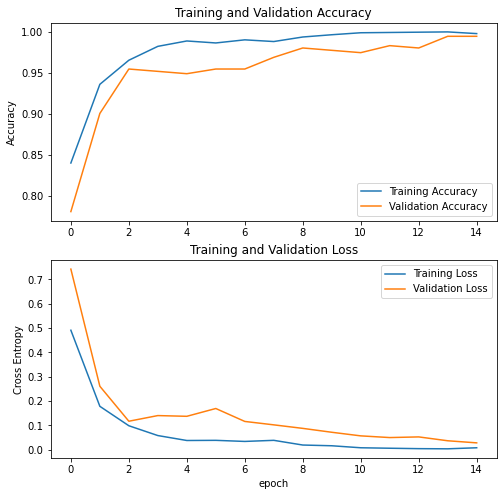

In [20]:
acc_qat = history_QAT.history['accuracy']
val_acc_qat = history_QAT.history['val_accuracy']

loss_qat = history_QAT.history['loss']
val_loss_qat = history_QAT.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_qat, label='Training Accuracy')
plt.plot(val_acc_qat, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_qat, label='Training Loss')
plt.plot(val_loss_qat, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
test_acc_qat = q_aware_model.evaluate(test, verbose=1)[1]
print('test acc:', str(round(test_acc_qat*100, 3))+"%")

367/367 [==============================] - 26s 70ms/step - loss: 0.0275 - accuracy: 0.9946
test acc: 99.455%


In [22]:
QAT_DIR ='./MODELS/QAT/'
q_aware_model.save(SAVE_DIR+"MOBILENET_FLOWERS_QAT.h5", include_optimizer=False)

In [24]:
converter_QAT = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter_QAT.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter_QAT.convert()

FILE = TFLITE_DIR + 'MOBILENETV2_FLOWERS_QAT.tflite'
with open(FILE, "wb") as f:
    f.write(quantized_tflite_model)

INFO:tensorflow:Assets written to: C:\Users\nikita\AppData\Local\Temp\tmp5i4al3_5\assets


INFO:tensorflow:Assets written to: C:\Users\nikita\AppData\Local\Temp\tmp5i4al3_5\assets
C:\Users\nikita\AppData\Roaming\Python\Python39\site-packages\tensorflow\lite\python\convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [29]:
y_test = list(map(lambda x: np.asarray(x[1])[0], test))
y_test

[2,
 3,
 3,
 4,
 3,
 0,
 0,
 0,
 0,
 1,
 3,
 2,
 4,
 1,
 2,
 1,
 2,
 4,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 3,
 0,
 1,
 1,
 1,
 2,
 1,
 0,
 0,
 1,
 1,
 0,
 3,
 0,
 4,
 4,
 3,
 0,
 4,
 3,
 3,
 2,
 4,
 0,
 1,
 2,
 1,
 3,
 0,
 1,
 4,
 1,
 0,
 2,
 3,
 0,
 0,
 4,
 0,
 1,
 1,
 0,
 1,
 2,
 4,
 3,
 3,
 0,
 3,
 2,
 2,
 1,
 0,
 3,
 2,
 0,
 0,
 4,
 3,
 0,
 3,
 3,
 2,
 0,
 2,
 1,
 4,
 0,
 3,
 3,
 3,
 1,
 4,
 0,
 4,
 4,
 4,
 4,
 0,
 4,
 2,
 3,
 4,
 0,
 0,
 4,
 4,
 4,
 2,
 2,
 4,
 4,
 3,
 3,
 0,
 3,
 2,
 0,
 1,
 2,
 1,
 4,
 3,
 0,
 2,
 0,
 2,
 2,
 4,
 0,
 3,
 0,
 0,
 1,
 2,
 0,
 1,
 2,
 3,
 1,
 2,
 2,
 0,
 3,
 3,
 4,
 0,
 4,
 0,
 4,
 0,
 2,
 2,
 1,
 0,
 2,
 4,
 0,
 0,
 0,
 1,
 1,
 0,
 4,
 1,
 4,
 4,
 3,
 1,
 0,
 1,
 2,
 3,
 4,
 0,
 0,
 3,
 2,
 4,
 1,
 0,
 0,
 4,
 4,
 2,
 0,
 3,
 4,
 0,
 0,
 1,
 3,
 2,
 0,
 2,
 2,
 3,
 4,
 0,
 1,
 4,
 1,
 0,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 0,
 4,
 2,
 4,
 1,
 0,
 0,
 4,
 2,
 1,
 0,
 3,
 2,
 1,
 4,
 3,
 1,
 3,
 0,
 0,
 2,
 3,
 4,
 0,
 1,
 2,
 4,
 0,
 3,
 1,
 0,
 1,
 2,
 4,
 0,


In [30]:
import time
def evaluate_tflite(mode_path, num_test):
    interpreter = tf.lite.Interpreter(model_path=mode_path)

    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]
    
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    print('input_details:  ', input_details)
    print('output_details: ', output_details)
    top_indices_tflite = []
    total_seen = 0
    num_correct = 0
    inference_time = []

    for batch in tqdm(test.take(int(num_test))):
        image = batch[0].numpy()
        start_ms = time.time()
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            image = image / input_scale + input_zero_point
        
        image = image.astype(input_details["dtype"])
        interpreter.set_tensor(interpreter.get_input_details()[0]["index"], image)
        interpreter.invoke()
        preds = interpreter.get_tensor(output_details["index"])
        top_inds = preds.argsort()[:,-5:][:,::-1]
        top_indices_tflite.append(top_inds[0])
        elapsed_ms = time.time() - start_ms
        inference_time.append(elapsed_ms * 1000.0)
        
        total_seen += 1

        if total_seen % 500 == 0:
            print("Accuracy after %i images: %f" %
              (total_seen, float(num_correct) / float(total_seen)))
    
    top_indices_tflite = np.array(top_indices_tflite)
    print('top-1 tflite accuracy:',np.mean(top_indices_tflite[:,0]==y_test[:len(top_indices_tflite)]))
    arr_of_k=[2,3,4,5]
    for k in arr_of_k:
        print('top-{} accuracy:'.format(k),
              np.mean(np.sum(top_indices_tflite[:,:k]==np.repeat(np.reshape(y_test,(-1,1)),k,axis=1),axis=1)))
# #     return np.array(top_indices_tflit

#     print('Num images: {0:}, Accuracy: {1:.4f}, Latency: {2:.2f} ms'.format(num_test,
#                                                                          float(num_correct / total_seen),
#                                                                          np.array(inference_time).mean()))

In [33]:
model_path_QAT = TFLITE_DIR + 'MOBILENETV2_FLOWERS_QAT.tflite'
evaluate_tflite(model_path_QAT, int(num_test))

input_details:   {'name': 'serving_default_input_3:0', 'index': 0, 'shape': array([  1, 224, 224,   3]), 'shape_signature': array([ -1, 224, 224,   3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
output_details:  {'name': 'StatefulPartitionedCall:0', 'index': 179, 'shape': array([1, 5]), 'shape_signature': array([-1,  5]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [10:59<00:00,  1.80s/it]

top-1 tflite accuracy: 0.9945504087193461
top-2 accuracy: 1.0
top-3 accuracy: 1.0
top-4 accuracy: 1.0
top-5 accuracy: 1.0
